In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re


from bs4 import BeautifulSoup
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS
from sklearn.feature_extraction.text import CountVectorizer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

%matplotlib inline

In [3]:
shopee_df = pd.read_csv('SHOPEE_REVIEWS2.csv',usecols=['review_text','review_rating', 'review_likes'])

In [4]:
# converting all review text to lowercase to normalize text
shopee_df.review_text = shopee_df.review_text.str.lower()

# sanity check
shopee_df.review_text

0       napaka bulok an tagal mag load ng tracking ord...
1       so unfair how about the student that have an p...
2             this is my favorite online store eversince.
3       love ko talaga ang shopee.kasi ni minsan hindi...
4                                                  hatdog
                              ...                        
6044                             good online shopping app
6045                                             good app
6046                                                    ❤
6047                                               nice 👍
6048    maganda yung app kasi maraming item na mura at...
Name: review_text, Length: 6049, dtype: object

In [5]:
# Check that the datatypes are correct
shopee_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6049 entries, 0 to 6048
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   review_text    6047 non-null   object
 1   review_rating  6049 non-null   int64 
 2   review_likes   6049 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 141.9+ KB


In [6]:
# Summary statistics for numerical variables
shopee_df.describe()

,review_rating,review_likes
count,6049.000000,6049.000000
mean,4.314267,0.988428
std,1.370609,24.058073
min,1.000000,0.000000
25%,5.000000,0.000000
50%,5.000000,0.000000
75%,5.000000,0.000000
max,5.000000,1426.000000


In [7]:
# Check how many reviews we have for each review rating after dropping the duplicates
shopee_df['review_rating'].value_counts().sort_index()

review_rating
1     739
2     131
3     202
4     395
5    4582
Name: count, dtype: int64

In [8]:
# Some null values in app version & developer replies
shopee_df.isnull().sum()

review_text      2
review_rating    0
review_likes     0
dtype: int64

### **Data Cleaning**

In [9]:
shopee_df.shape

(6049, 3)

In [10]:
shopee_df[shopee_df.duplicated(['review_text'])].shape

(1542, 3)

In [11]:
# Drop duplicates as we only want unique reviews
shopee_df.drop_duplicates(['review_text'], inplace=True)

In [12]:
# Reindex the dataframe
shopee_df.reset_index(drop=True, inplace=True)

In [13]:
shopee_df.shape


(4507, 3)

In [14]:
# Check how many reviews we have for each score after dropping the duplicates
shopee_df['review_rating'].value_counts().sort_index()

review_rating
1     705
2     124
3     177
4     301
5    3200
Name: count, dtype: int64

In [15]:
shopee_df.columns

Index(['review_text', 'review_rating', 'review_likes'], dtype='object')

## **Create a target variable**

The goal is to classify positive and negative app reviews. Negative reviews can reveal critical features that are missing from Shopee's app or even bring to light the presence of bugs on the app. This will require immediate action from Shopee. As such, priority will be placed on the prediction of negative sentiment. We will assign the negative reviews (scores 1-3) to class 1, and the positive reviews (scores 4-5) to class 0.

In [16]:
# Defining the target variable using scores
shopee_df['target'] = shopee_df['review_rating'].map(lambda x: 1 if x < 4 else 0)

In [17]:
# Check the count of our target variable
shopee_df['target'].value_counts()

target
0    3501
1    1006
Name: count, dtype: int64

In [18]:
# Check that the target variable has been added to our dataframe
shopee_df.head()

,review_text,review_rating,review_likes,target
0,napaka bulok an tagal mag load ng tracking ord...,1,0,1
1,so unfair how about the student that have an p...,1,0,1
2,this is my favorite online store eversince.,5,0,0
3,love ko talaga ang shopee.kasi ni minsan hindi...,5,0,0
4,hatdog,4,0,0


### **Pre-processing**

1. Remove HTML tags
1.   Use regular expression to remove special characters and numbers
2. Lowercase words
3. Use NLTK to remove stopwords
4. Remove frequently occurring words that appear in both positive and negative 5. sentiments, like 'app', 'shopee', 'item', 'seller', 'bad'. Removing these words led to a 1 and 2 percentage point improvement in our model's accuracy and recall rate, respectively.
6. Use NLTK to stem words to their root form. Note that the model returned better accuracy when we used stemming, rather than lemmatizing.

In [19]:
# Load Filipino stopwords from a .txt file taken from
# https://github.com/explosion/spaCy/blob/master/spacy/lang/tl/stop_words.py and
# https://github.com/stopwords-iso/stopwords-tl

# Initialize an empty list for Filipino stopwords
filipino_stopwords = []

# Load Filipino stopwords from the first .txt file
with open('genediazjr-tagalog.txt', 'r', encoding='utf-8') as file1:
    filipino_stopwords.extend([line.strip() for line in file1])

# Load Filipino stopwords from the second .txt file
with open('stopwords-tl.txt', 'r', encoding='utf-8') as file2:
    filipino_stopwords.extend([line.strip() for line in file2])

print(filipino_stopwords)

['ako', 'sa', 'akin', 'ko', 'aking', 'sarili', 'kami', 'atin', 'ang', 'aming', 'amin', 'ating', 'ka', 'iyong', 'iyo', 'inyong', 'siya', 'kanya', 'mismo', 'ito', 'nito', 'kanyang', 'sila', 'nila', 'kanila', 'kanilang', 'kung', 'ano', 'alin', 'sino', 'kanino', 'na', 'mga', 'iyon', 'am', 'ay', 'maging', 'naging', 'mayroon', 'may', 'nagkaroon', 'pagkakaroon', 'gumawa', 'ginagawa', 'ginawa', 'paggawa', 'ibig', 'dapat', 'maaari', 'marapat', 'kong', 'ikaw', 'tayo', 'hindi', 'namin', 'gusto', 'nais', 'niyang', 'nilang', 'niya', 'huwag', 'ginawang', 'gagawin', 'maaaring', 'sabihin', 'narito', 'kapag', 'ni', 'nasaan', 'bakit', 'paano', 'kailangan', 'walang', 'katiyakan', 'isang', 'at', 'pero', 'o', 'dahil', 'bilang', 'hanggang', 'habang', 'ng', 'pamamagitan', 'para', 'tungkol', 'laban', 'pagitan', 'panahon', 'bago', 'pagkatapos', 'itaas', 'ibaba', 'mula', 'pataas', 'pababa', 'palabas', 'ibabaw', 'ilalim', 'muli', 'pa', 'minsan', 'dito', 'doon', 'saan', 'lahat', 'anumang', 'kapwa', 'bawat', 'ilan

In [20]:
# Searching through a set is faster than searching through a list
import nltk
nltk.download('stopwords')

from nltk.corpus import stopwords

# Get the list of English stopwords
english_stopwords = set(stopwords.words('english'))

# Merge English and Filipino stopwords into one list
stops = english_stopwords.union(filipino_stopwords)

[nltk_data] Downloading package stopwords to C:\Users\Kismet
[nltk_data]     Suan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [21]:
# Write a function to convert raw text to a string of meaningful words
def stem_text(raw_text):
    raw_text = str(raw_text)
    # Remove HTML tags
    review_text = BeautifulSoup(raw_text).get_text()

    # Remove non-letters
    letters_only = re.sub("[^a-zA-Z]", " ", review_text)

    # Convert words to lower case and split each word up
    words = letters_only.lower().split()

    # Adding on stopwords that were appearing frequently in both positive and negative reviews
    stops.update(['app','shopee','shoppee','item','items','seller','sellers','bad', 'yung', 'lang', 'nyo', 'naman', 'di'])

    # Remove stopwords
    meaningful_words = [w for w in words if w not in stops]

    # Instantiate PorterStemmer
    p_stemmer = PorterStemmer()

    # Stem words
    meaningful_words = [p_stemmer.stem(w) for w in meaningful_words]

    # Join words back into one string, with a space in between each word
    return(" ".join(meaningful_words))

In [22]:
# Pre-process the raw text
shopee_df['content_stem'] = shopee_df['review_text'].map(stem_text)

C:\Users\Kismet Suan\AppData\Local\Temp\ipykernel_32292\1650195515.py:5: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  review_text = BeautifulSoup(raw_text).get_text()


In [1]:
# This is the original text of the first review in our dataset
shopee_df.loc[2]['review_text']

NameError: name 'shopee_df' is not defined

In [24]:
# This is how the text looks like after stemming
shopee_df.loc[0]['content_stem']

'bulok tagal mag load track order page aabot ata taon mag load bwisit ayusin bugok'

### **Remove reviews that do not have any meaningful words**
After pre-processing, we notice that there are some reviews that do not have any meaningful words left. As these reviews largely consists of only emojis or Chinese characters, these reviews returned blank fields after stemming. In
other words, the length of these reviews after pre-processing, was 0. Given that these reviews will not add value to our model's training, we will remove them from our dataset.

In [25]:
# Find the number of meaningful words in each review
shopee_df['content_clean_len'] = shopee_df['content_stem'].str.split().map(len)

In [26]:
# There are 6648 reviews that do not have any meaningful words
shopee_df[shopee_df['content_clean_len']==0].shape

(135, 6)

In [27]:
# View reviews that do not have any meaningful words
shopee_df[shopee_df['content_clean_len']==0]['review_text']

38                            😊😊😊😍😍😍
80                             👍👌🏻👌🏻
134           this app is not for me
162                            😍😍😍😍😍
178                             🥰🥰🥰🥰
                    ...             
4242                           😁😁😁😁😁
4371    🔰😑💞🐂😡😢💞🐂😡😆🐂😆😍🐂♓⌛♉♑🔝⌛🚰🔝♉♓🚮♉♓🚮
4406                            👏👏👏👏
4436                             😊😊😊
4437                              🥰😘
Name: review_text, Length: 135, dtype: object

In [28]:
# Drop these reviews that do not have any meaningful words
shopee_df = shopee_df.drop(shopee_df[shopee_df['content_clean_len']==0].index)

In [29]:
# Reindex the dataframe
shopee_df.reset_index(drop=True, inplace=True)

### **Create a train and test set**
20% of the original dataset will be set aside and used as a test set. This will be useful in evaluating our model's performance on unseen data.

In [30]:
# As we would like to stratify our target variable, we will need to first assign X and y
X = shopee_df[[cols for cols in shopee_df.columns if cols != 'target']]
y = shopee_df['target']

In [31]:
# Perform a train_test_split to create a train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [32]:
# Merge X_train and y_train back together using index
train = pd.merge(X_train, y_train, left_index=True, right_index=True)

# Merge X_test and y_test back together using index
test = pd.merge(X_test, y_test, left_index=True, right_index=True)

In [33]:
# Reindex the train and test set
train.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)

In [34]:
# 3497 documents in our training set
train.shape

(3497, 6)

In [35]:
# 875 documents in our test set
test.shape

(875, 6)

In [36]:
# Check split in class labels for training set
train['target'].value_counts(normalize=True)

target
0    0.77495
1    0.22505
Name: proportion, dtype: float64

In [37]:
# Check split in class labels for test set
test['target'].value_counts(normalize=True)

target
0    0.774857
1    0.225143
Name: proportion, dtype: float64

**367508** reviews for training and **91878** reviews in our test set.

The class representation is consistent across the train and test set

*   **74%** of the data belonging to class 0 (positive sentiment)
*   **25%** belonging to class 1 (negative sentiment)




# **Exploratory Data Analysis**


### Number of Likes received

Users can show their approval by giving a "thumbs up" to reviews on Shopee's app. A higher number of thumbs up received from the community will suggest that several others have also been experiencing the same issues.

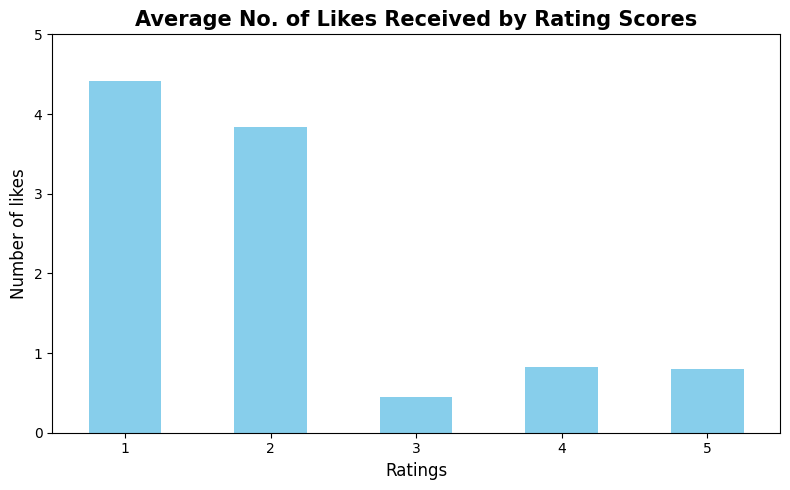

In [38]:
# Group by rating scores and find the average no. of thumbs up per score
train.groupby('review_rating')['review_likes'].mean().plot(kind='bar', figsize=(8,5), color='skyblue')
plt.xlabel('Ratings', fontsize=12)
plt.xticks(rotation=0)
plt.ylabel('Number of likes', fontsize=12)
plt.ylim(0,5)
plt.title('Average No. of Likes Received by Rating Scores', fontsize=15, weight='bold')
plt.tight_layout();

A review of **3 stars** has the **highest** likes received.
**5 star reviews** has the **lowest** likes

In [39]:
# Show the top 5 reviews that received the highest number of thumbs up
train[['review_text','review_likes','review_rating']].sort_values(by='review_likes', ascending=False).head()

,review_text,review_likes,review_rating
2903,all you need is here. great app and has a lot ...,1426,5
1887,immediately tags your product review as irrele...,866,1
1592,"average app, needs a lot of improvenents.",379,1
498,i cant use the shopee up! every time i'm tryin...,273,1
323,your shopping cart is soooooo laggy i can't de...,265,1


## **Number of meaningful words**


C:\Users\Kismet Suan\AppData\Local\Temp\ipykernel_32292\3650925066.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(neg_len, color='red', ax=ax[0])
C:\Users\Kismet Suan\AppData\Local\Temp\ipykernel_32292\3650925066.py:18: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(pos_len, color='green', a

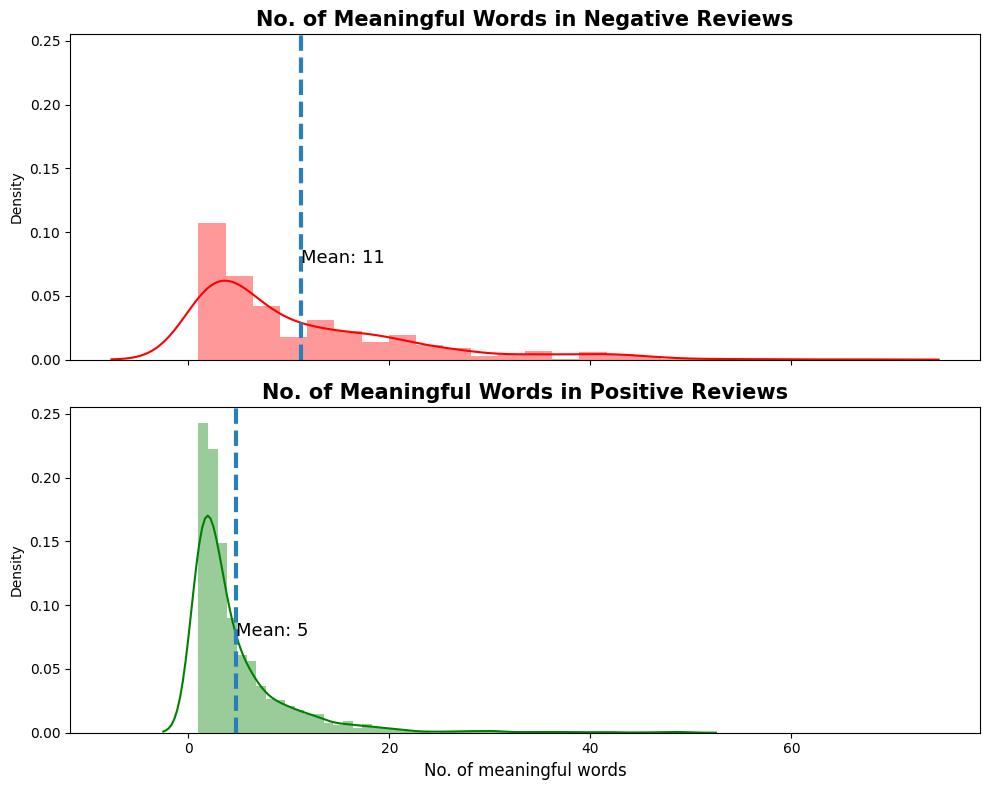

In [40]:
fig, ax = plt.subplots(2, 1, figsize=(10,8), sharex=True, sharey=True)

# Plots the distribution of the length of negative reviews
neg_len = train[train['target']==1]['content_clean_len']
sns.distplot(neg_len, color='red', ax=ax[0])
ax[0].axvline(neg_len.mean(), linestyle='dashed', linewidth=3, c='#2980B9') # Plot the mean line
ax[0].text(x=neg_len.mean(),
           y=0.08,
           s=f'Mean: {round(neg_len.mean())}',
           horizontalalignment='left',
           verticalalignment='center',
           fontsize=13)
ax[0].set_title('No. of Meaningful Words in Negative Reviews', fontsize=15, fontweight='bold')
ax[0].set_xlabel('No. of meaningful words', size=12)

# Plots the distribution of the length of positive reviews
pos_len = train[train['target']==0]['content_clean_len']
sns.distplot(pos_len, color='green', ax=ax[1])
ax[1].axvline(pos_len.mean(), linestyle='dashed', linewidth=3, c='#2980B9') # Plot the mean line
ax[1].text(x=pos_len.mean(),
           y=0.08,
           s=f'Mean: {round(pos_len.mean())}',
           horizontalalignment='left',
           verticalalignment='center',
           fontsize=13)
ax[1].set_title('No. of Meaningful Words in Positive Reviews', fontsize=15, fontweight='bold')
ax[1].set_xlabel('No. of meaningful words', size=12)
plt.tight_layout();

Distribution: **Right Skewed**

The average number of meaningful words in a negative review (12 words) is higher than that in a positive review (6 words).

Neg Reviews have higher variance in the number of meaningful words meaning dissatisfied customers are more likely to write longer reviews.

## **Wordcloud**

In [41]:
# Write a function to plot a wordcloud of the most frequently occurring words

def plot_wordcloud(target, title):

    # Clean text that we want to wordcloud. Target will be class 1 (negative reviews) or class 0 (positive reviews)
    text = train[train['target']==target]['content_stem']

    wordcloud = WordCloud(width=2000,
                          height=1000,
                          background_color='white',
                          max_words=50, # Maximum no. of words in the wordcloud
                          stopwords=STOPWORDS).generate(' '.join(text)) # Remove stopwords

    plt.figure(figsize=(10,8))
    plt.title(title, fontsize=15, weight='bold')
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off') # Removes the axis
    plt.tight_layout()

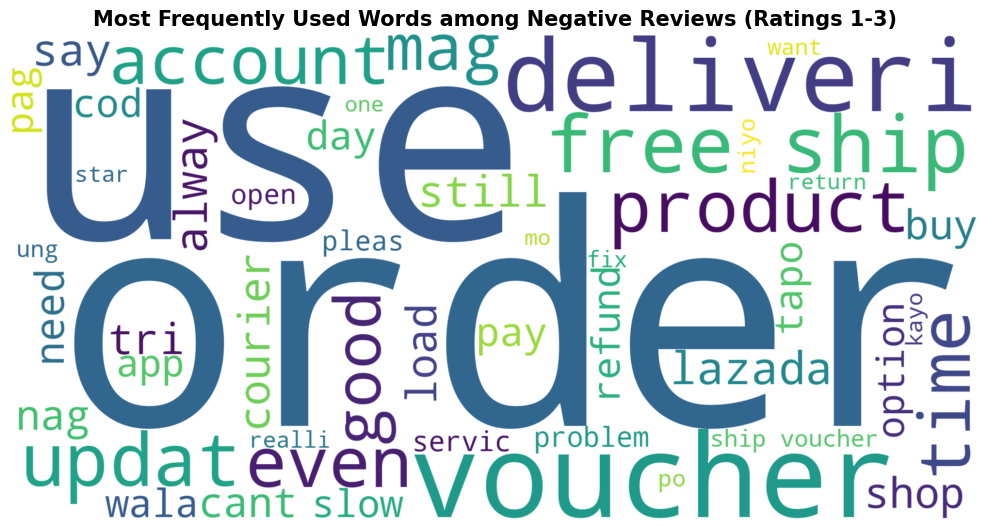

In [42]:
# Wordcloud of the 50 most frequently occurring words among negative reviews
plot_wordcloud(target=1, title='Most Frequently Used Words among Negative Reviews (Ratings 1-3)')

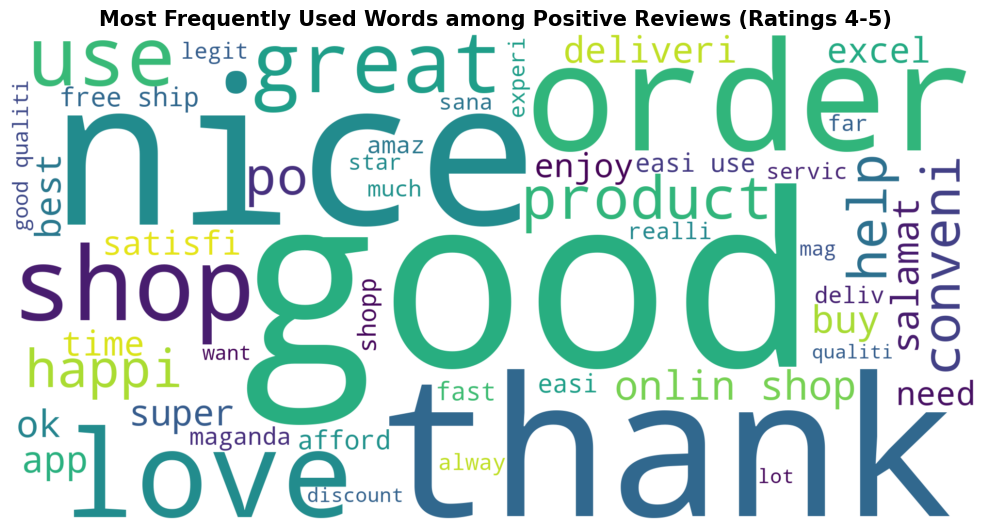

In [43]:
# Wordcloud of the 50 most frequently occurring words among positive reviews
plot_wordcloud(target=0, title='Most Frequently Used Words among Positive Reviews (Ratings 4-5)')

### **Barplots: Top uni-grams and bi-grams**

**To do:** Tokenize data and generate bar plots seen in each sentiment.

**Why:** To determine what specific words will help us distinguish between positive and negative sentiments


In [44]:
# Plots top 20 uni-grams and bi-grams for positive and negative reviews

def barplot_cvec(target, titles, color, xlimit):

    words_series = train[train['target']==target]['content_stem']

    fig, ax = plt.subplots(1, 2, figsize=(25,12))

    ngram = [(1,1),(2,2)] # The ngrams that we would like to plot

    for i in range(2):

        # Use CountVectorizer to tokenize the text,
        cvec = CountVectorizer(stop_words='english', ngram_range=ngram[i])

        # Save the tokens in a dataframe
        cvec_df = pd.DataFrame(cvec.fit_transform(words_series).todense(), columns=cvec.get_feature_names_out())
        sum_words = cvec_df.sum(axis=0) # Sum up the no. of occurences for each word
        top_words = sum_words.sort_values(ascending=False).head(20)
        top_words.sort_values(ascending=True).plot(kind='barh', color=color, ax=ax[i])

        # Adjust plot aesthetics
        ax[i].set_title(titles[i], size=25, weight='bold')
        ax[i].set_xlabel('Count', size=20)
        ax[i].set_xlim(xlimit) # Setting a limit so that the barplots are comparable
        ax[i].tick_params(axis='both', which='major', labelsize=20)
        ax[i].tick_params(axis='both', which='minor', labelsize=20)

    plt.tight_layout()

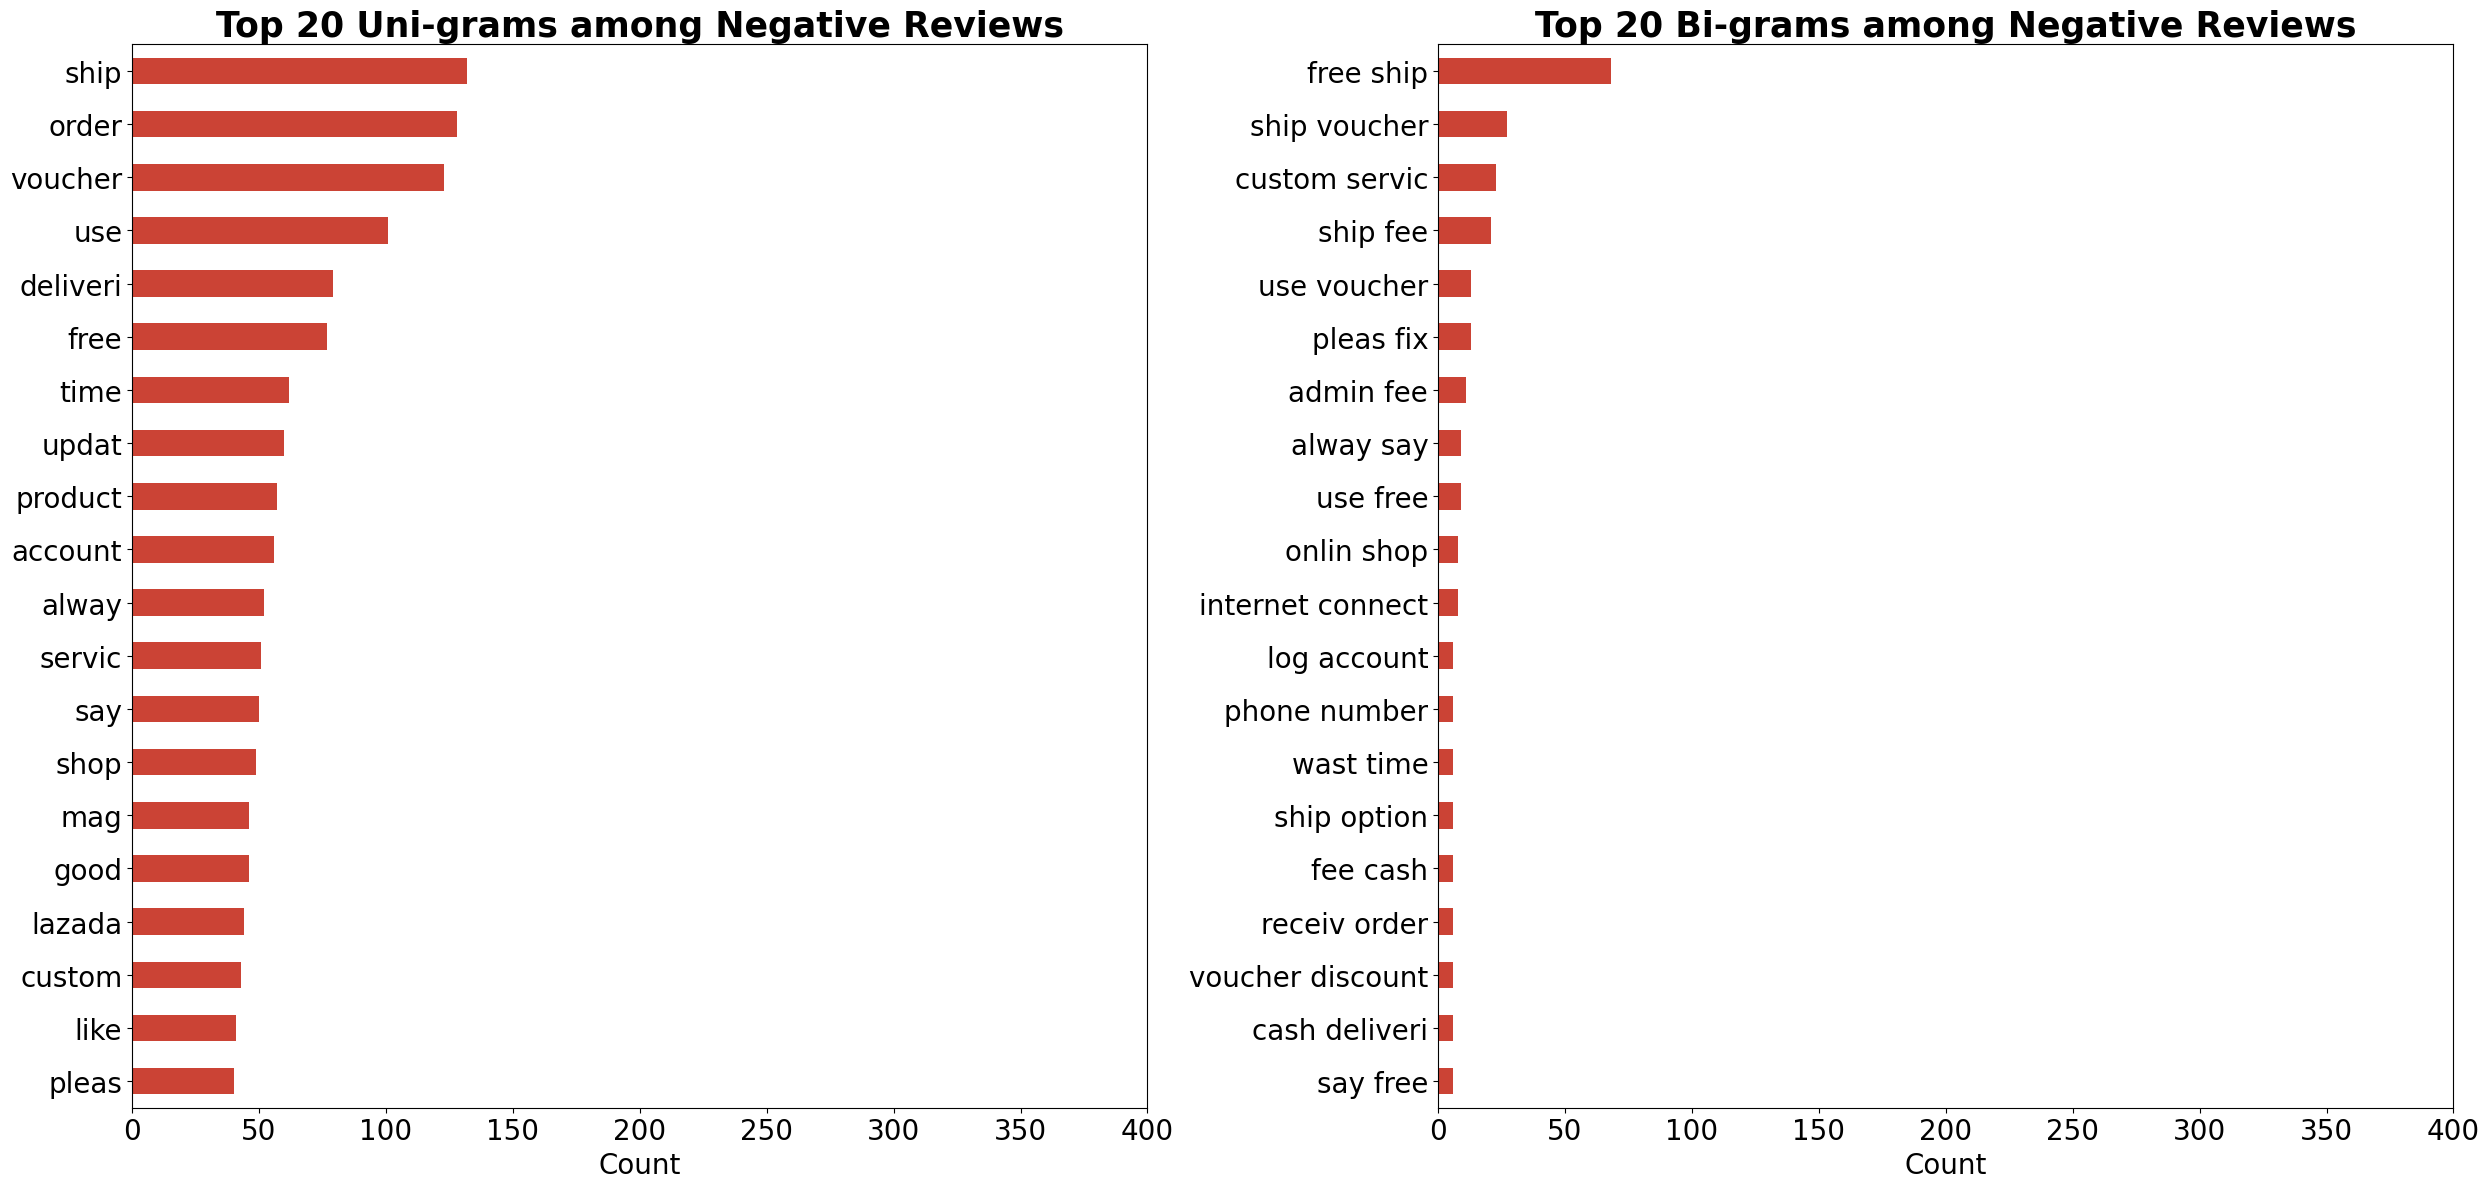

In [45]:
# Plot the uni-grams and bi-grams for negative reviews
barplot_cvec(target=1,
             titles=['Top 20 Uni-grams among Negative Reviews','Top 20 Bi-grams among Negative Reviews'], 
             color='#CB4335',
             xlimit=(0,400))

**Negative reviews.**

Unigram
Top 3 Most Frequent: **'Order', 'Ship'** and **'Voucher'**

bi-gram
**'Free Shipping' & 'Customer service'** are the top seen among negative reviews.

In [46]:
# Showing some of the negative reviews with the word ''Order'
train[(train['target']==1) & (train['content_stem'].str.contains('order'))][['review_text','review_rating']].head()

,review_text,review_rating
0,"this app, last month until today always say th...",1
25,nakakainis yun ninjavan sabi nandito na sa pla...,2
28,my ordered stiff seems a bit damage but it's fine,3
29,always late delivery. it takes almost 1 month ...,1
71,your app/platform became worse. ordered an ite...,1


In [75]:
# Assuming 'train' is your DataFrame
row_35 = train.iloc[29]

# Now, you can print the contents of cell 35
print(row_35)


review_text      always late delivery. it takes almost 1 month ...
content_stem     alway late deliveri take almost month receiv o...
review_rating                                                    1
target                                                           1
Name: 29, dtype: object


In [47]:
# Showing some of the negative reviews with the word ''Order'
train[(train['target']==1) & (train['content_stem'].str.contains('ship'))][['review_text','review_rating']].head()

,review_text,review_rating
0,"this app, last month until today always say th...",1
14,ang nakalagay kapag naka 500php minimum spend ...,1
56,"before, gustong gusto ko ang shopee pero ngayo...",2
71,your app/platform became worse. ordered an ite...,1
122,bakit ganun may bayad na shipping nila :( dami...,1


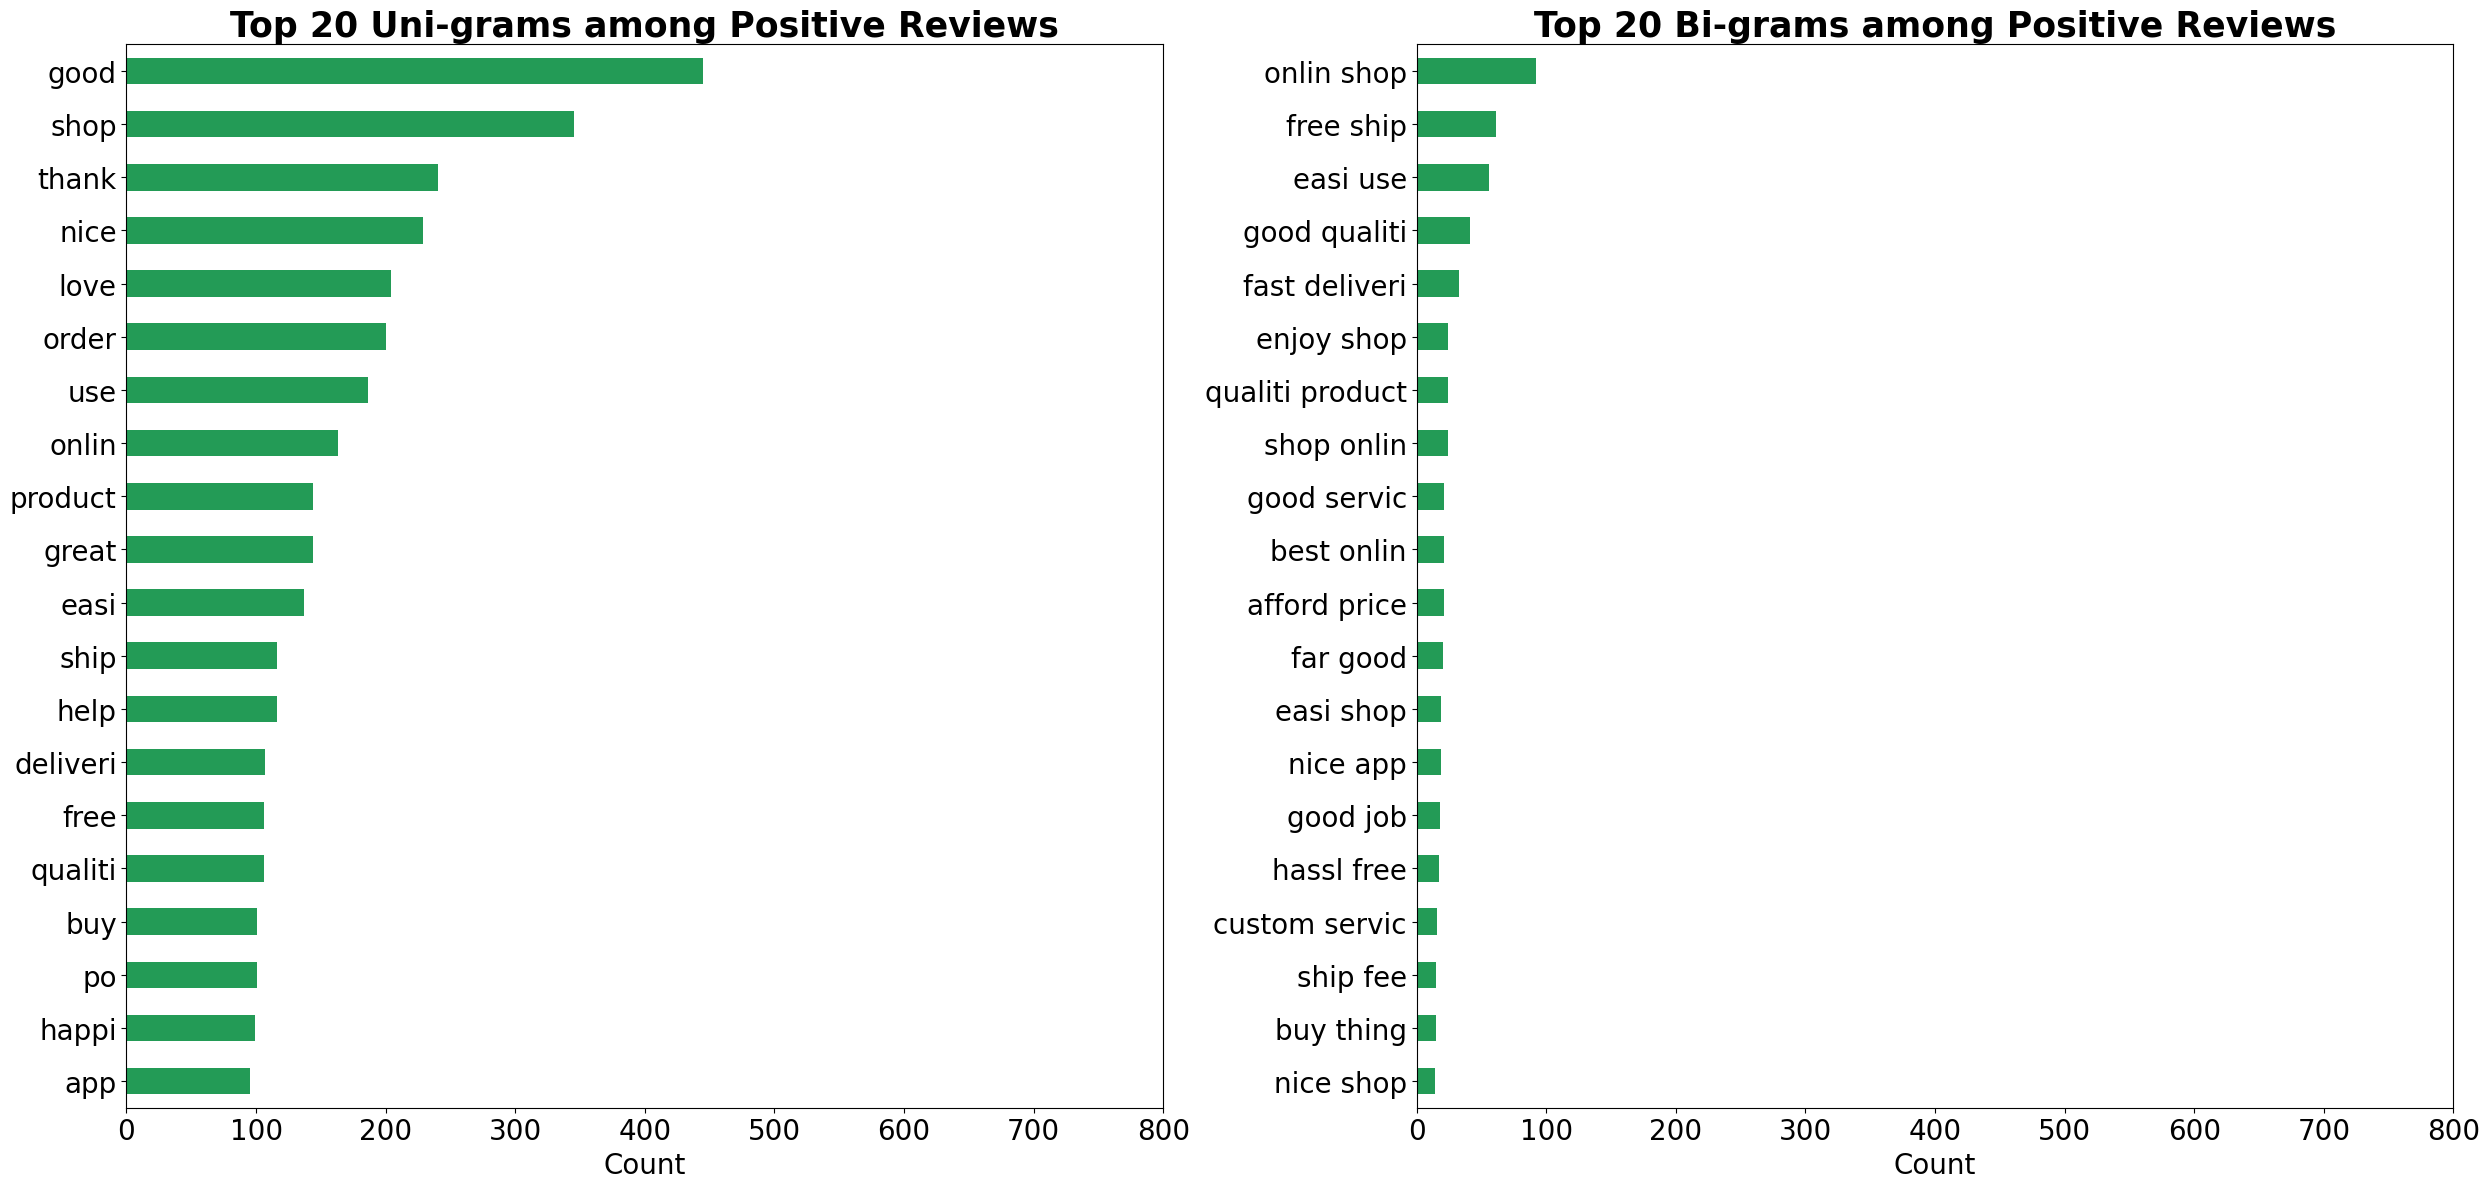

In [48]:
# Plot the uni-grams and bi-grams for positive reviews
barplot_cvec(target=0,
             titles=['Top 20 Uni-grams among Positive Reviews','Top 20 Bi-grams among Positive Reviews'], 
             color='#239B56',
             xlimit=(0,800))

In [70]:
# Showing some of the positive reviews with the word 'good'
train[(train['target']==0) & (train['content_stem'].str.contains('free'))][['review_text','review_rating']].head()

,review_text,review_rating
91,salamat shoppe i enjoy your free shipping,5
95,i love shopee lalo na ang free shipping and ca...,4
128,hassle free shopping.. convenient way to buy p...,5
131,very nice to free shipping everyday but i'm sa...,5
136,"maganda po,,nawili na po ako mag order dhil sa...",5


In [71]:
# Showing some of the positive reviews with the word 'good'
train[(train['target']==0) & (train['content_stem'].str.contains('good'))][['review_text','review_rating']].head()

,review_text,review_rating
4,"im happy to have app shopee no.1 i'd like,, ni...",5
15,verry good,5
16,good for finding stuff.,5
35,good shopping online store... may discount pal...,5
42,most of my items are more than worth to it's p...,5


In [73]:
# Assuming 'train' is your DataFrame
row_35 = train.iloc[35]

# Now, you can print the contents of cell 35
print(row_35)


review_text      good shopping online store... may discount pal...
content_stem                 good shop onlin store discount palagi
review_rating                                                    5
target                                                           0
Name: 35, dtype: object


In [50]:
# Showing some of the positive reviews with the word 'shop'
train[(train['target']==0) & (train['content_stem'].str.contains('onlin'))][['review_text','review_rating']].head()

,review_text,review_rating
9,isa ito sa paborito kong online shop. talagang...,5
10,"very useful in shoping online, less hustle.. t...",5
35,good shopping online store... may discount pal...,5
42,most of my items are more than worth to it's p...,5
44,affordable prices compared to other online shop 😊,5


<h1><b>Vader sentiment Analysis</b></h1>

In [51]:
# Instantiate the sentiment intensity analyzer
sia = SentimentIntensityAnalyzer()

In [52]:
# Print a negative review in the training set
print(train.loc[252,'review_text'])

# VADER's polarity scores for the negative review
sia.polarity_scores(train.loc[252,'review_text'])

lakas maka pang uto itong shopee refer daw kuno wala naman binibigay panay invite ko naman. sabi ng mga invite ko nag install na... tapos yong upgrade na shopay wala den... iba nalang shop totoo sila unlike this shop.. sa lazada madali mag refund more discount pa...haysss lipat na


{'neg': 0.048, 'neu': 0.89, 'pos': 0.062, 'compound': -0.0772}

In [53]:
# Create an empty list to append the polarity scores
sia_list = []

# Loop through the text in the training dataset and create a dictionary of the VADER scores
for text in train['review_text']:
    # Convert to string if 'text' is a float
        sia_dict = {}
        if isinstance(text, float):
            text = str(text)
        sia_dict['neg'] = sia.polarity_scores(text)['neg'] # Negative score
        sia_dict['neu'] = sia.polarity_scores(text)['neu'] # Neutral score
        sia_dict['pos'] = sia.polarity_scores(text)['pos'] # Positive scores
        sia_dict['compound'] = sia.polarity_scores(text)['compound'] # Compound scores
        sia_list.append(sia_dict) # Append the dictionary of scores to the sia_list

In [54]:
# Create a dataframe from the sia_list
sia_df = pd.DataFrame(sia_list)

In [55]:
# Include 'review_text' and 'target' in sia_df
sia_df['review_text'] = train['review_text']
sia_df['target'] = train['target']

In [56]:
# View first 5 rows of sia_df
sia_df.head()

,neg,neu,pos,compound,review_text,target
0,0.144,0.810,0.047,-0.5859,"this app, last month until today always say th...",1
1,0.528,0.472,0.000,-0.7728,bigla na lang akong na restrict. so disappoint...,1
2,0.000,0.213,0.787,0.5719,excellent service,0
3,0.000,1.000,0.000,0.0000,all my needed items nasa shopee na,0
4,0.000,0.665,0.335,0.9889,"im happy to have app shopee no.1 i'd like,, ni...",0


In [57]:
# Create empty lists to append the accuracy score for each compound score threshold level
threshold = []
accuracy = []

# Loop through a range of compound scores from -1 to +1 and calculate the accuracy score for each compound score
for i in np.linspace(-1, 1, 1000):
    vader_prediction = sia_df['compound'].map(lambda x: 0 if x > i else 1)
    score = accuracy_score(sia_df['target'], vader_prediction)
    threshold.append(i)
    accuracy.append(score)

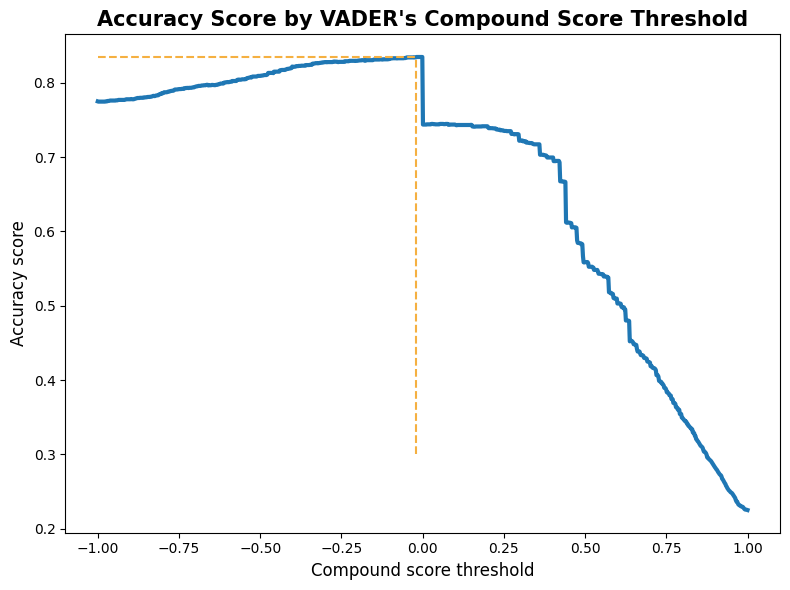

In [58]:
plt.figure(figsize=(8,6))

# Plots the accuracy score against compound score threshold
plt.plot(threshold, accuracy, linewidth=3)

# Plot a horizontal line that represents the best accuracy score achievable
plt.plot([-1,threshold[np.argmax(accuracy)]],[max(accuracy),max(accuracy)], linestyle='dashed', color='#F5B041')

# Plot a vertical line to show the corresponding compound score threshold for the best accuracy score
plt.plot([threshold[np.argmax(accuracy)],threshold[np.argmax(accuracy)]],[0.3,max(accuracy)], linestyle='dashed', color='#F5B041')

plt.title("Accuracy Score by VADER's Compound Score Threshold", size=15, weight='bold')
plt.ylabel('Accuracy score', size=12)
plt.xlabel('Compound score threshold', size=12)
plt.tight_layout()

In [59]:
print("VADER's best accuracy score: ", max(accuracy))
print('Compound score threshold: ', threshold[np.argmax(accuracy)])

VADER's best accuracy score:  0.8347154704032027
Compound score threshold:  -0.019019019019019034


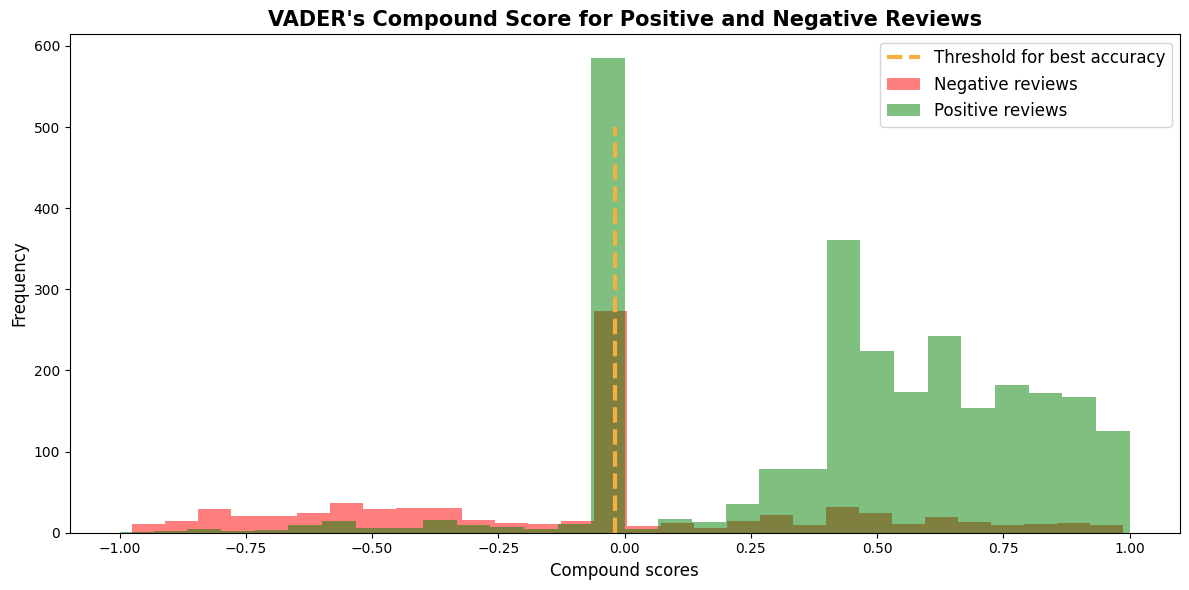

In [60]:
plt.figure(figsize=(12,6))

# Plot a histogram of the compound scores for negative reviews
sia_df[sia_df['target']==1]['compound'].hist(grid=False, color='red', alpha=0.5, bins=30)

# Plot a histogram of the compound scores for positive reviews
sia_df[sia_df['target']==0]['compound'].hist(grid=False, color='green', alpha=0.5, bins=30)

# Plot a vertical line to show the corresponding compound score threshold for the best accuracy score
plt.plot([threshold[np.argmax(accuracy)],threshold[np.argmax(accuracy)]],[0,500], linestyle='dashed', linewidth=3, color='#F5B041')

plt.title("VADER's Compound Score for Positive and Negative Reviews", size=15, weight='bold')
plt.legend(['Threshold for best accuracy','Negative reviews', 'Positive reviews'], fontsize=12)
plt.ylabel('Frequency', size=12)
plt.xlabel('Compound scores', size=12)
plt.tight_layout();

In order to achieve the highest accuracy score of 83% on the training set, the compound score threshold will need to be adjusted to -0.019. 

However, as seen by the peak around the 0 score mark, this threshold will result in quite a few misclassifications of positive reviews. These positive reviews are likely to consist of rather neutral sentiment, thus leading to borderline scores of around 0.

In [61]:
# Prediction with compound threshold of -0.019.
sia_df['vader_prediction'] = sia_df['compound'].map(lambda x: 0 if x > threshold[np.argmax(accuracy)] else 1)


In [62]:
# VADER's best accuracy score
accuracy_score(sia_df['target'], sia_df['vader_prediction'])

0.8347154704032027

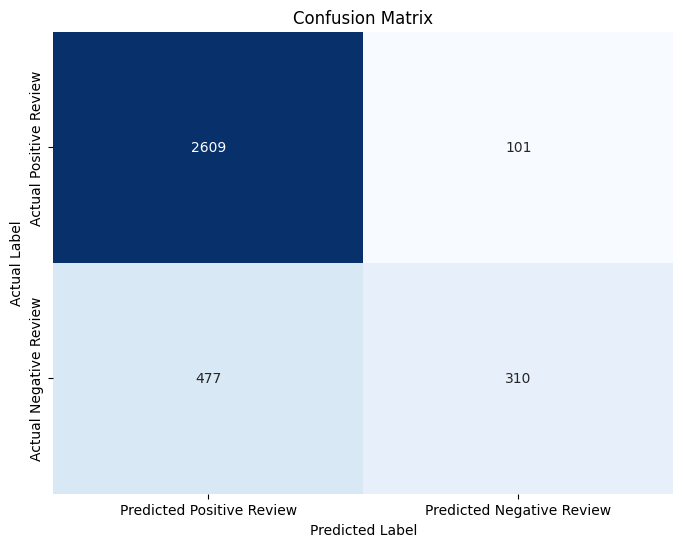

In [63]:
# Confusion matrix
#cm = confusion_matrix(sia_df['target'], sia_df['vader_prediction'])
#cm_df = pd.DataFrame(cm, columns=['Predicted Positive Review','Predicted Negative Review'], index=['Actual Positive Review', 'Actual Negative Review'])
#cm_df

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import pandas as pd

# Assuming you have sia_df DataFrame with 'target' and 'vader_prediction' columns
cm = confusion_matrix(sia_df['target'], sia_df['vader_prediction'])
cm_df = pd.DataFrame(cm, columns=['Predicted Positive Review', 'Predicted Negative Review'],
                     index=['Actual Positive Review', 'Actual Negative Review'])

# Plotting the confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.show()

In [64]:
# Classification report
print(classification_report(sia_df['target'], sia_df['vader_prediction']))

              precision    recall  f1-score   support

           0       0.85      0.96      0.90      2710
           1       0.75      0.39      0.52       787

    accuracy                           0.83      3497
   macro avg       0.80      0.68      0.71      3497
weighted avg       0.82      0.83      0.81      3497



Given a compound score threshold of -0.019, VADER is able to correctly classify 83% of sentiments. As Shopee's product managers would also like to prioritise the identification of negative reviews so that they can fix immediate problems if necessary, achieving a decent recall rate is important. VADER is only able to correctly classify 39% of actual negative reviews. 

In [65]:
# Negative reviews that were predicted to be positive reviews
sia_df[(sia_df['target']==1) & (sia_df['vader_prediction']==0)].head(10)

,neg,neu,pos,compound,review_text,target,vader_prediction
14,0.000,0.870,0.130,0.5562,ang nakalagay kapag naka 500php minimum spend ...,1,0
18,0.000,1.000,0.000,0.0000,superlike,1,0
25,0.000,1.000,0.000,0.0000,nakakainis yun ninjavan sabi nandito na sa pla...,1,0
28,0.171,0.650,0.179,0.0258,my ordered stiff seems a bit damage but it's fine,1,0
29,0.000,1.000,0.000,0.0000,always late delivery. it takes almost 1 month ...,1,0
33,0.000,0.888,0.112,0.5994,super laggy at the start whenever i open the a...,1,0
48,0.000,1.000,0.000,0.0000,nakakadismaya! scammer,1,0
55,0.000,0.408,0.592,0.4404,its good aps,1,0
56,0.038,0.901,0.060,0.3147,"before, gustong gusto ko ang shopee pero ngayo...",1,0
58,0.109,0.799,0.092,0.0129,after a year my shop bumababa ang benta. sa is...,1,0


In [66]:
# Positive reviews that were predicted to be negative reviews
sia_df[(sia_df['target']==0) & (sia_df['vader_prediction']==1)].head(10)

,neg,neu,pos,compound,review_text,target,vader_prediction
81,0.083,0.917,0.000,-0.2693,the system is unstable. i already paid for the...,0,1
100,0.462,0.256,0.282,-0.3400,ok po ang serbisyo.,0,1
136,0.145,0.723,0.133,-0.0772,"maganda po,,nawili na po ako mag order dhil sa...",0,1
157,0.545,0.455,0.000,-0.5574,"vli po kayo, garantisado",0,1
201,0.529,0.147,0.324,-0.3400,ok po salamat,0,1
213,1.000,0.000,0.000,-0.4215,ugh,0,1
214,0.077,0.923,0.000,-0.3612,napadami ako ng gastos pero di natin maiiwasan...,0,1
237,0.423,0.577,0.000,-0.2960,no problema. its legit,0,1
245,0.205,0.593,0.202,-0.2617,hassle free shopping and the price is good but...,0,1
283,0.046,0.919,0.035,-0.1017,i observed that if you use cod as mode of paym...,0,1


In [67]:
# Keep only the columns that we need for modeling and interpretation
train = train[['review_text','content_stem','review_rating','target']]
test = test[['review_text','content_stem','review_rating','target']]

In [68]:
# Save clean training set
train.to_csv('clean_train2.csv', index=False)

In [69]:
# Save clean test set
test.to_csv('clean_test2.csv', index=False)